In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
# Mac OS jupyter kernel dies without.
import os

from epi.models import Model, Parameter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12

### 1. Define the model.


In [3]:
N = 20
Js_eig_max_mean = 1.5
J_eig_realmax_mean = 0.5

def stable_amplification_r2(U, V):
    U = tf.reshape(U, (-1, N, 2))
    V = tf.reshape(V, (-1, N, 2))
    J = tf.matmul(U, tf.transpose(V, [0,2,1]))
    Js = (J + tf.transpose(J, [0, 2, 1])) / 2.
    Js_eigs = tf.linalg.eigvalsh(Js)
    Js_eig_max = tf.reduce_max(Js_eigs, axis=1)
    
    # Take eig of low rank similar mat
    Jr = tf.matmul(tf.transpose(V, [0,2,1]), U)
    Jr_tr = tf.linalg.trace(Jr)
    maybe_complex_term = tf.complex(tf.square(Jr_tr) + -4.*tf.linalg.det(Jr), 0.)
    J_eig_realmax = 0.5 * (Jr_tr + tf.math.real(tf.sqrt(maybe_complex_term)))
    
    T_x = tf.stack([Js_eig_max, tf.square(Js_eig_max-Js_eig_max_mean),
                    J_eig_realmax, tf.square(J_eig_realmax-J_eig_realmax_mean)], axis=1)
    return T_x





In [9]:
name = "Rank2Net"
params = []
M = Model(name, params)
epi_df = M.get_epi_df()
print(epi_df.columns)

Index(['Unnamed: 0', 'k', 'iteration', 'H', 'cost', 'converged', 'R1', 'R2',
       'R3', 'R4', 'path', 'init', 'arch', 'EP', 'AL_hps'],
      dtype='object')


Text(0, 0.5, '$|R(\\theta)|$')

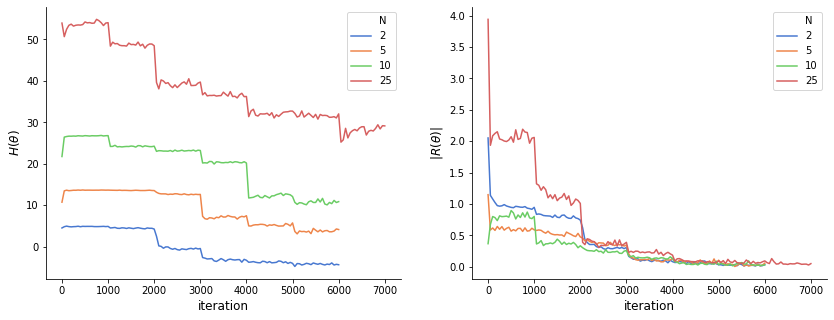

In [15]:
epi_df = M.get_epi_df()
epi_df['N'] = [row['init']['mu'].shape[0]//4 for i, row in epi_df.iterrows()]
epi_df['Rnorm'] = [np.linalg.norm([row['R%d' % j] for j in range(1,5)])
                   for i, row in epi_df.iterrows()]

fig, axs = plt.subplots(1,2,figsize=(14,5))
sns.lineplot(x='iteration', y='H', ax=axs[0], hue='N', data=epi_df, palette="muted")
axs[0].set_ylabel(r'$H(\theta)$')
sns.lineplot(x='iteration', y='Rnorm', ax=axs[1], hue='N', data=epi_df, palette="muted")
axs[1].set_ylabel(r'$|R(\theta)|$')

(1000, 4)


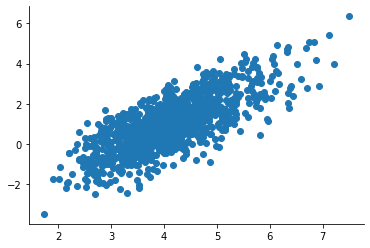

In [53]:
r = 2
B = 1000
N = 20

U = np.random.uniform(-1., 1., (B, N*r,)).astype(np.float32)
V = np.random.uniform(-1., 1., (B, N*r,)).astype(np.float32)

T_x = stable_amplification_r2(U, V)
print(T_x.shape)
plt.scatter(T_x[:,0], T_x[:,2])

In [5]:
D = N*r
lb = -np.ones((D,))
ub = np.ones((D,))
U = Parameter("U", D=D, lb=lb, ub=ub)
V = Parameter("V", D=D, lb=lb, ub=ub)

In [6]:
name = "Rank2Net"
params = [U, V]
M = Model(name, params)

In [7]:
M.set_eps(stable_amplification_r2)

In [8]:
from epi.normalizing_flows import NormalizingFlow
nf = NormalizingFlow(
    arch_type='coupling',
    D=2*D,
    num_stages=3,
    num_layers=2,
    num_units=4*D,
    batch_norm=False,
    bn_momentum=None,
    post_affine=False,
    bounds=M._get_bounds(),
    random_seed=1,
)

In [9]:
from epi.util import AugLagHPs
aug_lag_hps = AugLagHPs(500, 1e-3, 1., 0.25, 10.)

In [10]:
# Emergent property values
mu = np.array([1.5 , 0.25**2, .5, 0.25**2])

In [12]:
hp_df, opt_df = M.get_epi_dfs(mu, "")

Checking in data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/.
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D20_C3_L2_U40_rs1_N500_lr1.00E-03_c0=6.00E+00_gamma2.50E-01_beta1.00E+01/hps.p
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D200_C3_L2_U400_rs1_N500_lr1.00E-03_c0=0.00E+00_gamma2.50E-01_beta4.00E+00/hps.p
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D40_C3_L2_U80_rs1_N500_lr1.00E-03_c0=0.00E+00_gamma2.50E-01_beta4.00E+00/hps.p
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D80_C3_L2_U160_rs1_N500_lr1.00E-03_c0=0.00E+00_gamma2.50E-01_beta4.00E+00/hps.p
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D400_C3_L2_U800_rs1_N500_lr1.00E-03_c0=3.00E+00_gamma2.50E-01_beta1.00E+01/hps.p
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.

In [18]:
print(opt_df.columns)
opt_df.head()

Index(['Unnamed: 0', 'k', 'iteration', 'H', 'converged', 'R1', 'R2', 'R3',
       'R4', 'hp', 'Rnorm'],
      dtype='object')


,Unnamed: 0,k,iteration,H,converged,R1,R2,R3,R4,hp,Rnorm
0,0,0,0,53.950584,NaN,1.739201,3.432880,0.133842,0.838353,D100_C3_L2_U200_rs1_N500_lr1.00E-03_c0=3.00E+0...,3.940842
1,1,1,50,50.677100,NaN,1.113338,1.442430,-0.189779,0.621547,D100_C3_L2_U200_rs1_N500_lr1.00E-03_c0=3.00E+0...,1.934544
2,2,1,100,52.449364,NaN,1.095972,1.456927,-0.439248,0.914605,D100_C3_L2_U200_rs1_N500_lr1.00E-03_c0=3.00E+0...,2.086439
3,3,1,150,53.418224,NaN,1.126527,1.498832,-0.474768,0.877126,D100_C3_L2_U200_rs1_N500_lr1.00E-03_c0=3.00E+0...,2.123750
4,4,1,200,53.692520,NaN,1.103410,1.446933,-0.535087,1.013402,D100_C3_L2_U200_rs1_N500_lr1.00E-03_c0=3.00E+0...,2.150449


In [24]:
opt_df_conv = opt_df[opt_df['converged']==True]

In [43]:
Ns = [5, 10, 25, 50]
base_path = "data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/"
c0 = 3.

Ds = []
conv_iters = []
time_per_its = []
for N in Ns:
    D = 2*N*r
    Ds.append(D)
    D_str = 'D%d_' % D
    df = opt_df[opt_df['hp'].str.contains(D_str)].copy()
    c0_str = 'c0=%.2f' % c0
    df = df[df['hp'].str.contains(c0_str)]
    if df['converged'].any():
        conv_iters.append(df[df['converged']==True]['iteration'].to_numpy()[0])
    else:
        conv_iters.append(np.nan)
        
    save_path = df['hp'].iloc[0]
    timing_file = base_path + save_path + "/timing.npz"
    npzfile = np.load(timing_file)
    time_per_its.append(npzfile['time_per_it'])

Ds = np.array(Ds)
conv_iters = np.array(conv_iters)
time_per_its = np.array(time_per_its)
conv_times = conv_iters * time_per_its


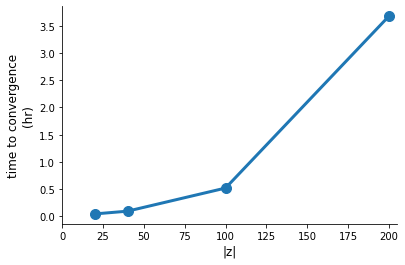

In [63]:
plt.figure()
plt.plot(Ds, conv_times/3600., '-o', lw=3, markersize=10)
plt.xlim([0, 205])
plt.xlabel('|z|')
plt.ylabel('time to convergence\n(hr)')
plt.show()

In [17]:
opt_df['Rnorm'] = opt_df[['R%d' % i for i in range(1, 5)]].pow(2.).sum(axis=1).pow(0.5)

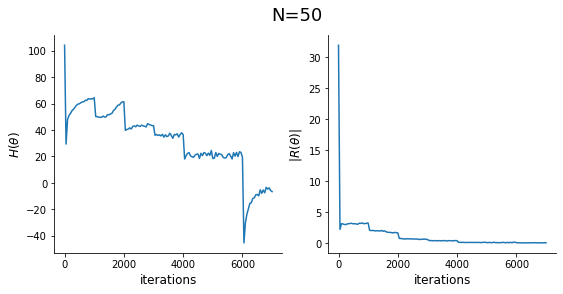

In [73]:
Ns = [50]
c0s = [3]
for N in Ns:
    D = 2*N*r
    D_str = 'D%d_' % D
    _opt_df = opt_df[opt_df['hp'].str.contains(D_str)].copy()
    fig, axs = plt.subplots(1,2, figsize=(9, 4))
    for c0 in c0s:
        c0_str = 'c0=%.2f' % c0
        df = _opt_df[_opt_df['hp'].str.contains(c0_str)]
        if df.shape[0] > 0:
            axs[0].plot(df['iteration'], df['H'], label=c0_str)
            axs[1].plot(df['iteration'], df['Rnorm'], label=c0_str)
    #axs[1].legend()
    axs[0].set_xlabel('iterations')
    axs[1].set_xlabel('iterations')
    axs[0].set_ylabel(r'$H(\theta)$')
    axs[1].set_ylabel(r'$|R(\theta)|$')
    plt.suptitle('N=%d' % N, fontsize=18)
    plt.show()

In [114]:
for i, hp_row in hp_df.iterrows():
    print(hp_row)
    dist = M.load_epi_dist(
        mu,
        k=1,
        arch_type=hp_row['arch_type'],
        num_stages=hp_row['num_stages'],
        num_layers=hp_row['num_layers'],
        num_units=hp_row['num_units'],
        batch_norm=hp_row['batch_norm'],
        post_affine=hp_row['post_affine'],
        N=hp_row['N'],
        lr=hp_row['lr'],
        c0=hp_row['c0'],
        gamma=hp_row['gamma'],
        beta=hp_row['beta'],
    )
    break

arch_type      coupling
num_stages            3
num_layers            2
num_units           200
batch_norm        False
bn_momentum        None
post_affine       False
random_seed           1
N                   500
lr                0.001
c0                    3
gamma              0.25
beta                 10
H               29.1405
Name: 1, dtype: object


TypeError: load_epi_dist() got multiple values for argument 'k'